In [533]:
import matplotlib as mpl
import numpy as np
import pandas as pd

import scipy as sp
import datetime

import matplotlib.pylab as plt
import os


import seaborn as sbn
from scipy.stats import norm
from scipy.stats import lognorm
import statsmodels.api as sm
import statsmodels.formula.api as smf
#from pykalman import KalmanFilter
#from johansen import coint_johansen

from datetime import datetime
from dateutil import relativedelta
from scipy.stats import norm
import quandl


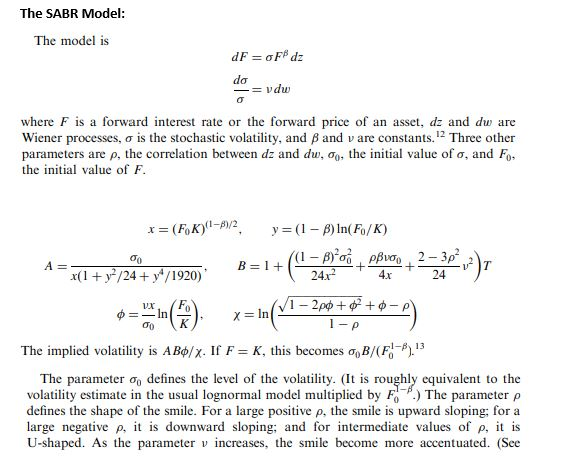

In [534]:
'''SABR analytical formula for arriving at lognormal Black implied volatility'''
def SABR(F0,K,T,alpha,beta,rho,nu):
    x=(F0*K)**((1-beta)/2)
    y=(1-beta)*np.log(F0/K)
    A=alpha/(x*(1+(y**2)/24+(y**4)/1920))
    B=1+((((1-beta)**2)*(alpha**2)/(24*x**2))  +  (rho*beta*nu*alpha/(4*x)) + ((2-3*rho**2)*nu**2)/24)*T
    phi=nu*x*np.log(F0/K)/alpha
    chi=np.log((np.sqrt(1-2*rho*phi+phi**2)+phi-rho)/(1-rho))
    if F0==K:
        iv = alpha*B/(F0**(1-beta))
    elif (F0==0 or K==0):
        iv=0
    else:
        iv=A*B*phi/chi
    return iv

In [535]:
'''Sample data for calculations '''
Fk=0.07  # Forward LIBOR rate for the period covered by caplet

Rf=0.065 #continously compounded risk free rate for that period
Rk=0.08 # cap rate compunded quarterly
l= 10000000 #$10MM Notional amount
tenor = 0.25 #tenor is 3 months 
sigma=0.2 #volatility of forward rate is 20% pa
strike=[0.04,0.0425,0.045,0.0475,0.05,0.0525,0.055,0.0575,0.06,0.0625,0.065,0.0675,0.07,0.0725,0.075,0.0775,0.08,0.0825,0.085,0.0875,0.09,0.0925,0.095,0.0975,0.1]

sigma_K=[0.5,0.48,0.43,0.35,0.31,0.3,0.295,0.29,0.285,0.28,0.275,0.27,0.265,0.26,0.255,0.257,0.259,0.2599,0.261,0.2615,0.263,0.265,0.266,0.267,0.268] #Black implied vols from market
#sigma_K=[0.225,0.229,0.226,0.225,0.23,0.231,0.235,0.239,0.245]
T=1.25 #Cap starting in 1 year
tk=1
w,y,z=0.2,0.2,0.2
var=[w,y,z]
beta=0.6

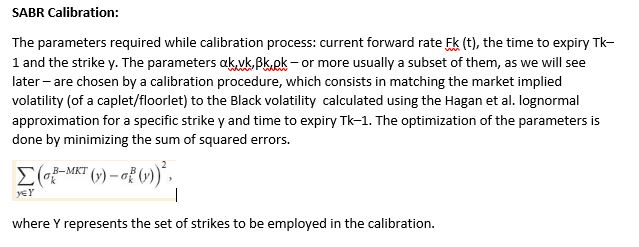

In [536]:
'''SABR Calibration function, calculates the SABR implied volatility for different strikes with predetermined beta'''
def calibration(var):

    store=[]
    for k in range(0,len(strike)):
        SE= float((SABR(Fk,strike[k],T,var[0],beta,var[1],var[2])-sigma_K[k]))**2
        
        store.append(SE)
    return sum(store)


In [537]:
'''Minimization of SABR Calibration function with starting value provided for alpha, beta, rho and nu'''
from scipy.optimize import minimize
bnds = ( (0.001,None) , (-0.999,0.999) , (0.001,None) )
res=minimize(calibration, np.array([0.22,-0.7,0.2]), method='SLSQP',bounds=bnds)


In [538]:
print('alpha: {:.4%}' .format(res.x[0]))
print('pre determined beta: {:.2}' .format(beta))
print('rho: {:.4}' .format(res.x[1]))
print('vol of vol: {:.4}' .format(res.x[2]))


alpha: 7.8420%
pre determined beta: 0.6
rho: -0.2086
vol of vol: 1.094


In [539]:
'''function to get SABR implied volatility for various strike prices'''
def smile(beta_value):
    IV=[]
    for k in range(0,len(strike)):
        calib_vol=SABR(Fk,strike[k],T,res.x[0],beta_value,res.x[1],res.x[2])
        IV.append(calib_vol)
    return IV

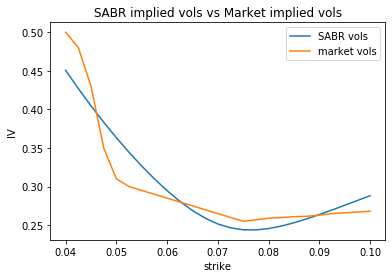

In [541]:

plt.plot(strike,smile(beta),label='SABR vols')
plt.plot(strike,sigma_K,label='market vols')
plt.title('SABR implied vols vs Market implied vols')
plt.ylabel('IV')
plt.xlabel('strike')
plt.legend()
plt.show()

In [542]:
'''Black analytical formula for arriving at Caplet/floorlet prices using SABR lognormal implied volatility'''
def Black(F_k,R_k,vol,tenor,L,t_k,t_kplus1,discount_rate,type):
    d1=(np.log(F_k/R_k)+(vol**2)*t_k*0.5)/(vol*np.sqrt(t_k))
    d2=d1-vol*np.sqrt(t_k)
    discount_factor=np.exp(-discount_rate*t_kplus1)
    caplet=L*tenor*discount_factor*(-R_k*norm.cdf(d2)+F_k*norm.cdf(d1))
    floorlet=L*tenor*discount_factor*(R_k*norm.cdf(-d2)-F_k*norm.cdf(-d1))
    if type ==1:
        return caplet
    elif type==0:
        return floorlet

In [543]:
'''Caplet price of the sample data described above'''
Black(Fk,Rk,SABR(Fk,Rk,T,res.x[0],beta,res.x[1],res.x[2]),tenor,l,tk,T,Rf,1)

7789.643540168112

In [544]:
Beta_range=[x for x in np.arange(0.0,1.0,0.05)]

In [545]:
Beta_range

[0.0,
 0.05,
 0.1,
 0.15000000000000002,
 0.2,
 0.25,
 0.30000000000000004,
 0.35000000000000003,
 0.4,
 0.45,
 0.5,
 0.55,
 0.6000000000000001,
 0.65,
 0.7000000000000001,
 0.75,
 0.8,
 0.8500000000000001,
 0.9,
 0.9500000000000001]

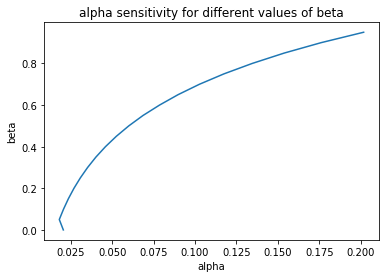

In [546]:
'''Relationship of beta and alpha for different set of beta values'''

alpha_list=[]
rho_list=[]
volofvol=[]
for b in Beta_range:
    def calib(var):

        store=[]
        for k in range(0,len(strike)):
            SE= float((SABR(Fk,strike[k],T,var[0],b,var[1],var[2])-sigma_K[k]))**2
        
            store.append(SE)
        return sum(store)
    
    from scipy.optimize import minimize
    bnds = ( (0.001,None) , (-0.999,0.999) , (0.001,None) )
    res=minimize(calib, np.array([0.22,-0.7,3]), method='SLSQP',bounds=bnds)
    alpha_list.append(res.x[0])
    rho_list.append(res.x[1])
    volofvol.append(res.x[2])

plt.plot(alpha_list,Beta_range)
plt.title('alpha sensitivity for different values of beta')
plt.ylabel('beta')
plt.xlabel('alpha')
plt.show()